# 1. AAL atlas

In [1]:
import sys

sys.path.append('../')

In [2]:
from src.utils import initialize_experiment

experiment = initialize_experiment()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/etokone/fmri-la5c-study/13f4c3ae2f5145729ef7071837e472c2



In [3]:
import os 

from src.utils import calc_all_sub_ts

from nilearn import image as nimg
from nilearn import plotting as nplot
from nilearn import datasets
from bids.layout import BIDSLayout

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

%matplotlib inline

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [4]:
# Base directory for fmriprep output
fmriprep_dir = '../data/ds000030/derivatives/fmriprep/'
layout = BIDSLayout(fmriprep_dir,
                        config=['bids', 'derivatives'])

In [5]:
atlas_aal = datasets.fetch_atlas_aal()


Dataset created in /home/neuro/nilearn_data/aal_SPM12



 ...done. (2 seconds, 0 min)
Extracting data from /home/neuro/nilearn_data/aal_SPM12/a2fc9a441ebe10d638e4a74b1d3c1dac/aal_for_SPM12.tar.gz..... done.


In [6]:
params = {
    'parcel_file': atlas_aal['maps'],
    'confounds': ['trans_x', 'trans_y', 'trans_z', 
                  'rot_x', 'rot_y', 'rot_z', 
                  'white_matter', 'csf', 'global_signal'],
    'high_pass': 0.009,
    'low_pass': 0.08,
    'detrend': True,
    'standardize': True,
    'tr_drop': 4
    
}
experiment.log_parameters(params)

In [7]:
from nilearn import input_data

masker = input_data.NiftiLabelsMasker(labels_img=params['parcel_file'],
                                      standardize=params['standardize'],
                                      memory='nilearn_cache',
                                      detrend=params['detrend'],
                                      low_pass=params['low_pass'],
                                      high_pass=params['high_pass'],
                                      t_r=2)

In [8]:
ctrl_subjects_raw, schz_subjects_raw, labels_list = calc_all_sub_ts(layout, params, masker)

  0%|                                                    | 0/17 [00:00<?, ?it/s]/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/input_data/nifti_labels_masker.py:486: UserWarning: Persisting input arguments took 1.00s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  verbose=self.verbose)
100%|███████████████████████████████████████████| 17/17 [00:51<00:00,  3.05s/it]


Control group connectivity matrix shape (7, 116, 116)


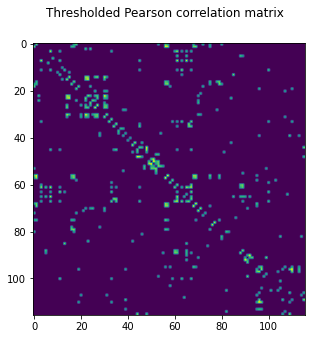

{'web': 'https://www.comet.ml/api/asset/download?assetId=67d7a279cae6476ab59eb24d06ffaa09&experimentKey=13f4c3ae2f5145729ef7071837e472c2',
 'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=67d7a279cae6476ab59eb24d06ffaa09&experimentKey=13f4c3ae2f5145729ef7071837e472c2',
 'assetId': '67d7a279cae6476ab59eb24d06ffaa09'}

In [9]:
from nilearn.connectome import ConnectivityMeasure
from sklearn.covariance import EmpiricalCovariance

covariance_estimator = EmpiricalCovariance()
connectivity_correlation = ConnectivityMeasure(kind="correlation", cov_estimator=covariance_estimator)

# Calculate pearson correlation
R_ctrl = connectivity_correlation.fit_transform(ctrl_subjects_raw)
print(f'Control group connectivity matrix shape {R_ctrl.shape}')

# Tresholding
R_tresholded = R_ctrl[0].copy()
np.fill_diagonal(R_tresholded, 0)
R_tresholded[R_tresholded < 0.5] = 0.0

# Visualise
fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))
plt.suptitle("Thresholded Pearson correlation matrix")
ax1.imshow(R_tresholded)
plt.show()

experiment.log_confusion_matrix(matrix=R_tresholded)

## Network visualization

In [10]:
# ROIs coordinates
coordinates = nplot.find_parcellation_cut_coords(labels_img=atlas_aal["maps"])

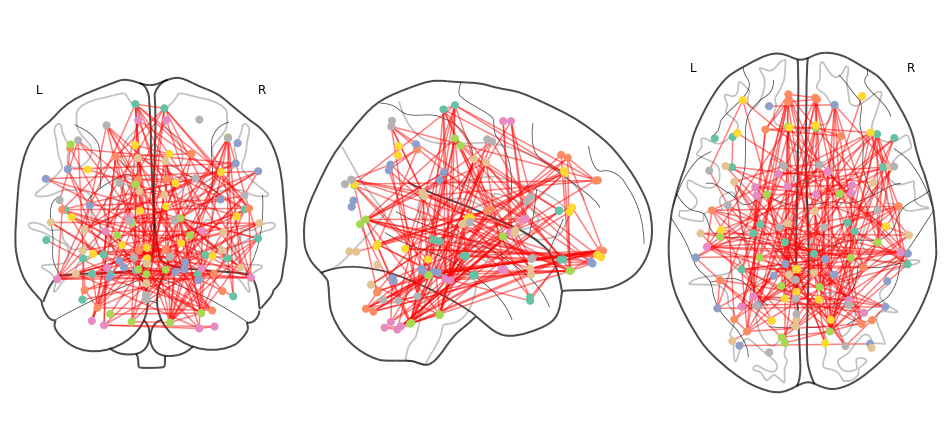

In [11]:
# nilearn graph drawing
fig = plt.figure(figsize=(13,6))
edge_options = {"color": "r", "linewidth": 1.5, "alpha": 0.5}
nplot.plot_connectome(R_tresholded, coordinates, figure=fig, edge_kwargs=edge_options)

In [12]:
import networkx as nx
#import diagram2vec

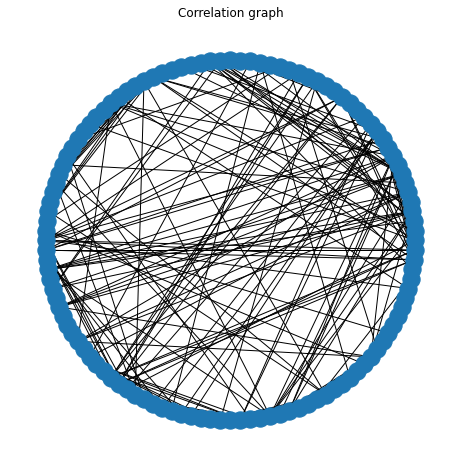

In [13]:
# matplotlib graph drawing
fig, (ax1) = plt.subplots(1, 1, figsize=(8,8))
ax1.set_title("Correlation graph")
nx.draw_shell(nx.from_numpy_array(R_tresholded), ax=ax1)
plt.show()

## Network analysis

### Graph-theoretic

[networkx docs](https://networkx.org/documentation/stable/index.html)

<img src="./static/graph_features.png"/>

We have connectivity matrix, and we want to create graph

In [32]:
G = nx.from_numpy_array(R_tresholded)

### Node degree

The degree of a node is the number of edges connected to the node.

For directed network, we check in and out degrees 

In [24]:
degree = np.array([degree[1] for degree in nx.degree(G)])
degree

array([10,  8,  2,  8,  0,  4,  1,  7,  1,  0,  1,  8,  2,  3,  7,  5,  7,
        8,  5,  3,  4,  1, 10,  7,  6,  3,  7,  6,  3,  0, 11,  8,  1,  8,
        3,  5,  2,  1,  4,  5,  1,  1,  3,  1,  4,  8,  4,  2,  4,  2,  4,
        4,  6,  6,  2,  2, 10,  9,  4,  3,  5, 14,  0,  8,  2, 11,  4, 13,
        6,  6,  6,  3,  3,  1,  1,  8,  1,  1,  2,  5,  4,  1,  3,  1,  2,
        2,  1,  0,  5,  7,  3,  5,  3,  1,  0,  9,  8,  5,  1,  3,  5,  1,
        0,  1,  2,  3,  3,  4,  1,  5,  6,  0,  0,  4,  2,  4])

In [25]:
degree.shape

(116,)

### Average neighbor degree 

$$k_{nn, i} = \frac{1}{| N(i) |} \displaystyle\sum_{j\in\ N(i)} k_j$$

where **N(i)** are the neighbors of node **i**,

and **k_j** is the degree of node **j** which belongs to **N(i)**

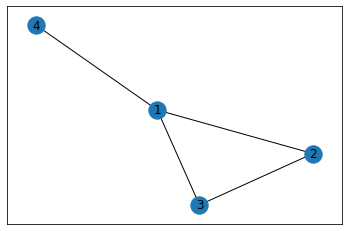

In [39]:
G_ex = nx.Graph()
G_ex.add_edges_from([(1, 2), (2, 3), (1, 3), (1, 4)])
nx.draw_networkx(G_ex)
plt.show()

In [42]:
neighbor_degree_avg = np.array(list(nx.average_neighbor_degree(G_ex).values()))
neighbor_degree_avg

array([1.66666667, 2.5       , 2.5       , 3.        ])

In [44]:
first_nn = 1/3 * (2 + 2 + 1)
first_nn

1.6666666666666665

In [33]:
neighbor_degree_avg = np.array(list(nx.average_neighbor_degree(G).values()))
neighbor_degree_avg

array([ 6.7       ,  8.        ,  8.        ,  9.25      ,  0.        ,
        9.25      ,  1.        , 10.        ,  1.        ,  0.        ,
        2.        ,  8.25      ,  3.        ,  6.        ,  7.71428571,
        7.4       ,  7.14285714,  7.625     ,  5.2       ,  6.33333333,
        7.5       ,  3.        ,  6.5       ,  7.        ,  5.5       ,
        7.66666667,  7.42857143,  8.33333333,  3.66666667,  0.        ,
        6.        ,  7.        ,  8.        ,  7.25      ,  5.66666667,
        8.4       ,  2.5       ,  2.        ,  3.        ,  4.8       ,
        1.        ,  1.        ,  2.33333333,  3.        ,  5.        ,
        7.25      ,  3.        ,  6.        ,  5.        ,  4.        ,
        4.5       ,  4.5       ,  3.33333333,  4.83333333,  5.        ,
        6.5       ,  7.6       ,  7.55555556,  4.5       ,  5.66666667,
        9.4       ,  7.21428571,  0.        ,  8.25      ,  6.        ,
        6.18181818,  8.75      ,  7.53846154,  8.66666667,  8.33

### Centralities

- **Betweenness centrality** is a way of detecting the amount of influence a node has over the flow of information in a graph. It is often used to find nodes that serve as a bridge from one part of a graph to another.

- The algorithm calculates unweighted shortest paths between all pairs of nodes in a graph. Each node receives a score, based on the number of shortest paths that pass through the node. Nodes that more frequently lie on shortest paths between other nodes will have higher betweenness centrality scores.

$$C_{B}(v) = \sum_{s, t \in V}\frac{\sigma(s,t|v)}{\sigma(s,t)}$$

**where** $$V$$ is the set of nodes, $$\sigma(s, t)$$ is the number of shortest **(s, t)**-paths, and $$\sigma(s, t|v)$$ is the number of those paths passing through some node **v** other than **s, t**. 

In [45]:
centrality_betweenness = np.array(list(nx.betweenness_centrality(G).values()))
centrality_betweenness

array([0.10880407, 0.00263297, 0.        , 0.01433075, 0.        ,
       0.        , 0.        , 0.00651965, 0.        , 0.        ,
       0.        , 0.00628693, 0.01479786, 0.00208409, 0.00271859,
       0.02929062, 0.01412852, 0.00961552, 0.09252382, 0.02463033,
       0.01066572, 0.        , 0.04631959, 0.03953821, 0.06449489,
       0.00044622, 0.00474349, 0.00025593, 0.00996323, 0.        ,
       0.04170034, 0.04762479, 0.        , 0.12013285, 0.00038563,
       0.00367631, 0.01479786, 0.        , 0.04138141, 0.04832342,
       0.        , 0.        , 0.0343168 , 0.        , 0.0259622 ,
       0.0473344 , 0.04164184, 0.        , 0.0259622 , 0.        ,
       0.00732265, 0.00732265, 0.05901201, 0.08525992, 0.0197054 ,
       0.03902484, 0.04536318, 0.00383053, 0.03922048, 0.02251313,
       0.00044132, 0.06526847, 0.        , 0.01125647, 0.01479786,
       0.10177151, 0.00329068, 0.05821827, 0.01280668, 0.00769309,
       0.07819585, 0.01479786, 0.01479786, 0.        , 0.     

In [49]:
max((val, idx) for idx, val in enumerate(centrality_betweenness))

(0.14620126682729917, 95)

In [13]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/etokone/fmri-la5c-study/6b1f8e18e44e4e68aa4cc4ff1d2ed389
COMET INFO:   Parameters:
COMET INFO:     confounds   : ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'white_matter', 'csf', 'global_signal']
COMET INFO:     detrend     : True
COMET INFO:     high_pass   : 0.009
COMET INFO:     low_pass    : 0.08
COMET INFO:     parcel_file : /home/neuro/nilearn_data/aal_SPM12/aal/atlas/AAL.nii
COMET INFO:     standardize : True
COMET INFO:     tr_drop     : 4
COMET INFO:   Uploads:
COMET INFO:     confusion-matrix         : 1
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (15.53 MB)
COMET INFO:     installed pa